## 推荐系统
- 基于商品相似性的推荐
- 基于SVD矩阵分解的推荐

In [1]:
import pandas as pd
import numpy as np
import time
import sqlite3

data_home='./'

## 数据读取
在数据中需要：用户，歌曲，播放量

In [2]:
RawDataset=pd.read_csv(filepath_or_buffer=data_home+'train_triplets.txt',
                    sep='\t',header=None,
                   names=['user','song','play_count'])

In [3]:
RawDataset.head(10)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


In [4]:
RawDataset.shape

(48373586, 3)

In [5]:
RawDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user        object
 1   song        object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ GB


## 统计每个用户的播放总量


In [6]:
UserPlayDict={}
with open(data_home+'train_triplets.txt') as f:
    for line_number,line in enumerate(f):
        user=line.split('\t')[0] #遍历每一行的第一个元素为用户名
        play_count=int(line.split('\t')[2])
        if user in UserPlayDict:
            play_count +=UserPlayDict[user] #已存在此用户的信息时，只更新 播放次数
            UserPlayDict.update({user:play_count})
        UserPlayDict.update({user:play_count})# 如果遍历出来的用户不在字典里，则更新一组键值对
    UserPlayList=[{'user':k,'play_count':v} for k,v in UserPlayDict.items()] #把字典里的弄到数组里？
    UserPlayDf=pd.DataFrame(UserPlayList) #将数组转换成df形式
    UserPlayDfSort=UserPlayDf.sort_values(by='play_count',ascending=False) #按照播放次数的大小排序
        

In [7]:
UserPlayDfSort.to_csv(path_or_buf='UserPlayDfSort.csv',index=False) #存入本地

In [8]:
UserPlayDfSort.head()

,user,play_count
669980,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13132
402687,119b7c88d58d0c6eb051365c103da5caf817bea6,9884
964856,3fa44653315697f42410a30cb766a4eb102080bb,8210
462404,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,7015
991089,d7d2d888ae04d16e994d6964214a1de81392ee04,6494


## 统计每一首歌的播放总量

In [9]:
# 与统计每个用户的总播放量 方法一样，直接copy
SongPlayDict={}
with open(data_home+'train_triplets.txt') as f:
    for line_number,line in enumerate(f):
        song=line.split('\t')[1] #遍历每一行的第一个元素为用户名
        play_count=int(line.split('\t')[2])
        if song in SongPlayDict:
            play_count +=SongPlayDict[song] #已存在此用户的信息时，只更新 播放次数
            SongPlayDict.update({song:play_count})
        SongPlayDict.update({song:play_count})# 如果遍历出来的用户不在字典里，则更新一组键值对
    SongPlayList=[{'song':k,'play_count':v} for k,v in SongPlayDict.items()] #把字典里的弄到数组里？
    SongPlayDf=pd.DataFrame(SongPlayList) #将数组转换成df形式
    SongPlayDfSort= SongPlayDf.sort_values(by='play_count',ascending=False) #按照播放次数的大小排序
SongPlayDfSort.to_csv(path_or_buf='SongPlayDfSort.csv',index=False) #存入本地

In [10]:
SongPlayDfSort.head()

,song,play_count
202,SOBONKR12A58A7A7E0,726885
199,SOAUWYT12A81C206F1,648239
218,SOSXLTC12AF72A7F54,527893
22,SOFRQTD12A81C233C0,425463
206,SOEGIYH12A6D4FC0E3,389880


## 去掉惰性用户（只听一两次歌的人）
注意要分别命名每个用户和每个歌曲的总播放量，否则下面会出现混淆，得出90%的比例

In [11]:
TotalPlayCount=sum(SongPlayDfSort.play_count)
print(  float(  UserPlayDfSort.head(n=100000).play_count.sum()  /  TotalPlayCount ) *100 )
# 取前10万个用户的总播放次数 除 歌曲的总播放次数 ->得出占比40%

40.8807280500655


In [12]:
float(SongPlayDfSort.head(30000).play_count.sum()/TotalPlayCount)*100
#取前3万首歌的总播放量 除 歌曲总播放量 - >得出占比78%

78.39315366645269

In [13]:
# 经过人工分析，我们可取10w个用户，三万首歌
UserPlayDfSort_10w=UserPlayDfSort.head(100000)
SongPlayDfSort_3w=SongPlayDfSort.head(30000)
User10w = list(UserPlayDfSort_10w.user)
Song3w = list(SongPlayDfSort_3w.song)

## 记住！命名注意关键词！！！ 不要叫 list，会覆盖掉内置的

In [14]:
UserPlayDfSort_10w.shape

(100000, 2)

## 过滤掉不符合逻辑的情况
- 比如 前10w个用户中听的歌 不包含在新的歌曲列表中
- 同样 前3w首被播放的歌 不存在于新的用户列表中

In [15]:
RawDataset.head(10)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


In [16]:
# f_user.shape
RawDataset.shape

(48373586, 3)

In [18]:
FilterDataset=RawDataset[RawDataset.user.isin(User10w)]# 去掉不在前10w用户列表中的其他数据
SecFilterDataset=FilterDataset[FilterDataset.song.isin(Song3w)]#去掉经处理过的 且不在前3w歌曲列表中的其他数据
# 保存在本地
SecFilterDataset.to_csv(path_or_buf=data_home+'User10w_Song3w.csv',index=False)

过滤后的数据

In [19]:
SecFilterDataset.shape 

(10774558, 3)

In [20]:
SecFilterDataset.head()

,user,song,play_count
498,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
499,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
500,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
501,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
502,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7


## 加入音乐详细信息
- 把db数据库信息读入（注意！只需要前3w首（还是经过其他不合理筛选的））
- 转换成df格式
- 与现有数据表合并在一起

In [21]:
conn = sqlite3.connect(data_home+'track_metadata.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

[('songs',)]

In [22]:
AllMsg = pd.read_sql(con=conn, sql='select * from songs')
Song3wMsg= AllMsg[AllMsg.song_id.isin(Song3w)]# 筛选出前3万歌曲的全部详细信息

In [23]:
Song3wMsg.to_csv(path_or_buf=data_home+'Song3wMsg.csv', index=False)

In [24]:
Song3wMsg.shape

(30447, 14)

## 我们现有的数据


In [25]:
Song3wMsg.head(5) #经过筛选的含有详细信息的歌曲数据

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
115,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
123,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
145,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
172,TRMMHBF12903CF6E59,At the Ball_ That's All,SOJGCRL12A8C144187,Best of Laurel & Hardy - The Lonesome Pine,AR1FEUF1187B9AF3E3,4a8ae4fd-ad6f-4912-851f-093f12ee3572,Laurel & Hardy,123.71546,0.438709,0.307120,0,8645877,-1,0
191,TRMMHKG12903CDB1B5,Black Gold,SOHNFBA12AB018CD1D,Total Life Forever,ARVXV1J1187FB5BF88,6a65d878-fcd0-42cf-aff9-ca1d636a8bcc,Foals,386.32444,0.842578,0.514523,2010,9007438,-1,0


### 去掉不需要的、重复的信息（列）

In [26]:
del(Song3wMsg['track_id'])
del(Song3wMsg['artist_mbid'])
#去掉重复的行信息
Song3wMsg=Song3wMsg.drop_duplicates(['song_id'])
Song3wMsg.head()

,title,song_id,release,artist_id,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
115,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
123,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
145,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
172,At the Ball_ That's All,SOJGCRL12A8C144187,Best of Laurel & Hardy - The Lonesome Pine,AR1FEUF1187B9AF3E3,Laurel & Hardy,123.71546,0.438709,0.307120,0,8645877,-1,0
191,Black Gold,SOHNFBA12AB018CD1D,Total Life Forever,ARVXV1J1187FB5BF88,Foals,386.32444,0.842578,0.514523,2010,9007438,-1,0


In [27]:
Song3wMsg.shape #经去重处理后，变成没有重复的3w首歌曲

(30000, 12)

## merge操作
- 通过观察，得到下面这个表的song_id列与原来的new_dataset表的song列是对应的
- 进行merge操作

In [28]:
MergedAllMsg3w=pd.merge(SecFilterDataset,Song3wMsg,
                           how='left',left_on='song',right_on='song_id')
MergedAllMsg3w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10774558 entries, 0 to 10774557
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user                object 
 1   song                object 
 2   play_count          int64  
 3   title               object 
 4   song_id             object 
 5   release             object 
 6   artist_id           object 
 7   artist_name         object 
 8   duration            float64
 9   artist_familiarity  float64
 10  artist_hotttnesss   float64
 11  year                int64  
 12  track_7digitalid    int64  
 13  shs_perf            int64  
 14  shs_work            int64  
dtypes: float64(3), int64(5), object(7)
memory usage: 1.2+ GB


In [29]:
MergedAllMsg3w.rename(columns={'play_count':'listen_count'},inplace=True)
# 把play_count改成listen_count.无关紧要的操作
MergedAllMsg3w.head()

,user,song,listen_count,title,song_id,release,artist_id,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,SOADQPP12A67020C82,Tribute To Jake Hess,ARDFZE61187FB45994,Jake Hess,199.26159,0.374553,0.327544,2004,142275,-1,0
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,SOAFTRR12AF72A8D4D,Discovery,ARF8HTQ1187B9AE693,Daft Punk,223.60771,0.902841,1.021256,2007,485119,-1,0
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,SOANQFY12AB0183239,Uprising,ARR3ONV1187B9A2F59,Muse,304.84853,0.929030,0.750427,0,6024257,-1,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,SOAYATB12A6701FD50,Home,AR97V5X1187FB4AE98,Deep Blue Something,257.22730,0.655889,0.409729,1993,163047,-1,0
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),SOBOAFP12A8C131F36,We Sing. We Dance. We Steal Things.,ARML3X41187FB35F2E,Jason Mraz & Colbie Caillat,189.62240,0.842972,0.770117,0,2638597,-1,0


### 删除其他无关紧要的信息（列）

In [30]:
# 去掉不需要的指标
del(MergedAllMsg3w['song_id'])
del(MergedAllMsg3w['artist_id'])
del(MergedAllMsg3w['duration'])
del(MergedAllMsg3w['artist_familiarity'])
del(MergedAllMsg3w['artist_hotttnesss'])
del(MergedAllMsg3w['track_7digitalid'])
del(MergedAllMsg3w['shs_perf'])
del(MergedAllMsg3w['shs_work'])
MergedAllMsg3w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10774558 entries, 0 to 10774557
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user          object
 1   song          object
 2   listen_count  int64 
 3   title         object
 4   release       object
 5   artist_name   object
 6   year          int64 
dtypes: int64(2), object(5)
memory usage: 575.4+ MB


## 可视化(●'◡'●)
- 最流行的音乐
- 最受欢迎的歌手

In [31]:
popular_songs=MergedAllMsg3w[['title','listen_count']].groupby('title').sum().reset_index()
# 将歌曲以歌名分组，按照被播放的次数重新排序
popular_songs.head()

,title,listen_count
0,I Will Not Reap Destruction,1022
1,!@*$%#,362
2,#!*@ You Tonight [Featuring R. Kelly] (Explici...,695
3,#1,525
4,#1 Stunna,457


注意下面有个报错（上面也发生过）
- TypeError: 'list' object is not callable
- 可能是由于自己写的东西覆盖了，目前通过.tolist()方式解决

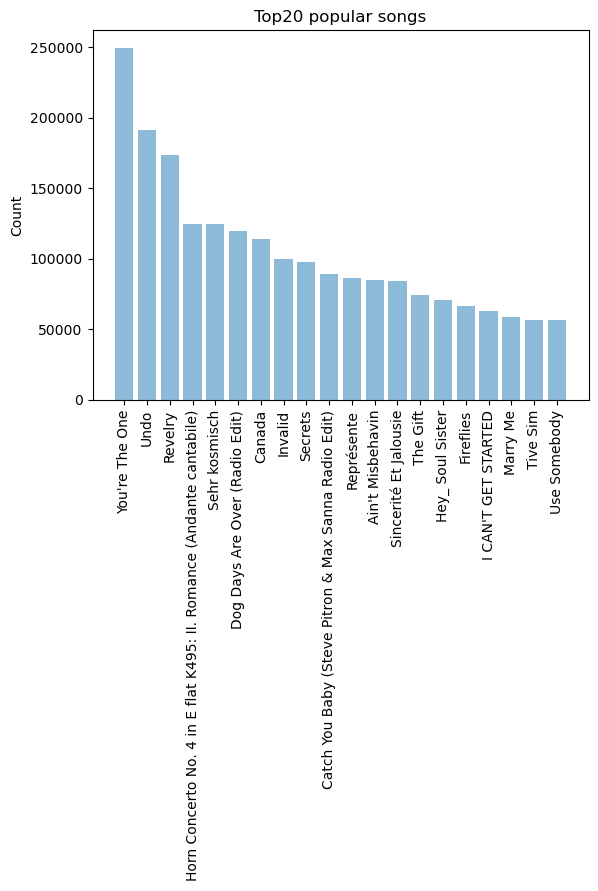

In [32]:
top20_songs=popular_songs.sort_values('listen_count',ascending=False).head(20)
# print(top20_songs)

import matplotlib.pyplot as plt
import numpy as np

objects=(top20_songs['title']).tolist()
y_num=np.arange(len(objects))
# performance=list(top20_songs['listen_count'])
performance=top20_songs['listen_count'].tolist()

plt.bar(y_num,performance,align='center',alpha=0.5)
plt.xticks(y_num,objects,rotation='vertical')
plt.ylabel('Count')
plt.title('Top20 popular songs')

plt.show()

最受欢迎的歌手

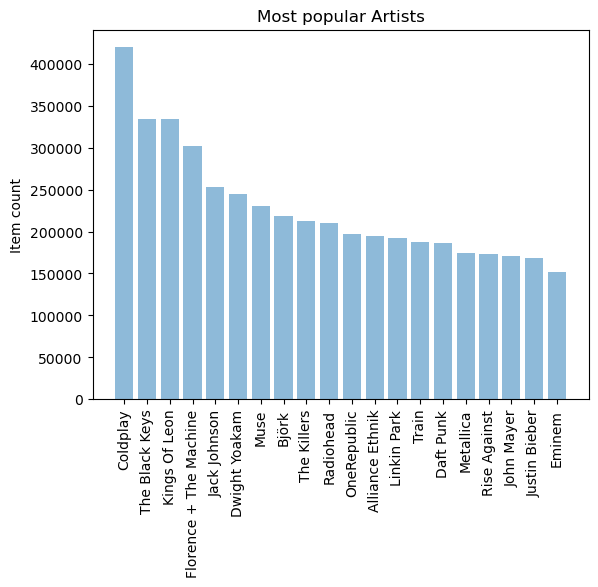

In [33]:
#按歌手来统计其播放总量
popular_artist = MergedAllMsg3w[['artist_name','listen_count']].groupby('artist_name').sum().reset_index()
#排序
popular_artist_top_20 = popular_artist.sort_values('listen_count', ascending=False).head(n=20)

objects = (popular_artist_top_20['artist_name']).tolist()
y_pos = np.arange(len(objects))
performance = popular_artist_top_20['listen_count'].tolist()
#绘图 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Artists')
 
plt.show()

### 用户播放量的分布

In [34]:
user_count_distribution = MergedAllMsg3w[['user','title']].groupby('user').count().reset_index().sort_values(
by='title',ascending = False)
user_count_distribution.title.describe()

count    99996.000000
mean       107.749890
std         79.742561
min          1.000000
25%         53.000000
50%         89.000000
75%        141.000000
max       1189.000000
Name: title, dtype: float64

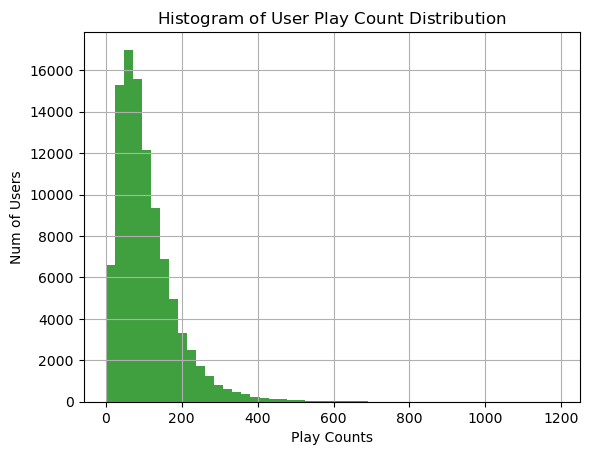

In [35]:
x = user_count_distribution.title
n, bins, patches = plt.hist(x, 50, facecolor='green', alpha=0.75)
plt.xlabel('Play Counts')
plt.ylabel('Num of Users')
plt.title(r'$\mathrm{Histogram\ of\ User\ Play\ Count\ Distribution}\ $')
plt.grid(True)
plt.show()

# 推荐系统

## 1、基于物品的协同过滤

In [36]:
import Recommenders as Recommenders
from sklearn.model_selection import train_test_split

### 简单暴力，排行榜 榜单推荐

（没看）

In [37]:
MergedAllMsg3w_set=MergedAllMsg3w
train_data,test_data=train_test_split(MergedAllMsg3w_set,test_size = 0.40, random_state=0)
train_data.head()

,user,song,listen_count,title,release,artist_name,year
1901799,28866ea8a809d5d46273cd0989c5515c660ef8c7,SOEYVHS12AB0181D31,1,Monster,The Fame Monster,Lady GaGa,2009
4815185,c9608a24a2a40e0ec38993a70532e7bb56eff22b,SOKIYKQ12A8AE464FC,2,Fight For Your Life,Made In NYC,The Casualties,2000
10513026,24f0b09c133a6a0fe42f097734215dceb468d449,SOETFVO12AB018DFF3,1,Free Style (feat. Kevo_ Mussilini & Lyrical 187),A Bad Azz Mix Tape,Z-RO,0
2659073,4da3c59a0af73245cea000fd5efa30384182bfcb,SOAXJOU12A6D4F6685,1,Littlest Things,Alright_ Still,Lily Allen,2006
5506263,b46c5ed385cad7ecea8af6214f440d19de6eb6c2,SOXBCAY12AB0189EE0,1,La trama y el desenlace,Amar la trama,Jorge Drexler,2010


In [38]:
# 把点击量当成得分值
def create_popularity_recommendation(train_data, user_id, item_id):
    #根据指定的特征来统计其播放情况，可以选择歌曲名，专辑名，歌手名
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    #为了直观展示，我们用得分来表示其结果
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
    #排行榜单需要排序
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])
    
    #加入一项排行等级，表示其推荐的优先级
    train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
    #返回指定个数的推荐结果
    popularity_recommendations = train_data_sort.head(20)
    return popularity_recommendations

In [39]:
recommendations = create_popularity_recommendation(MergedAllMsg3w_set,'user','title')

In [40]:
recommendations

,title,score,Rank
19580,Sehr kosmisch,18626,1.0
5780,Dog Days Are Over (Radio Edit),17635,2.0
27314,You're The One,16085,3.0
19542,Secrets,15138,4.0
18636,Revelry,14945,5.0
25070,Undo,14687,6.0
7530,Fireflies,13085,7.0
9640,Hey_ Soul Sister,12993,8.0
25216,Use Somebody,12793,9.0
9921,Horn Concerto No. 4 in E flat K495: II. Romanc...,12346,10.0


## 基于歌曲相似度的推荐
选5000的样本容量来实验

In [41]:
# SongPlayDfSort.info()
# AllMsg.info()
MergedAllMsg3w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10774558 entries, 0 to 10774557
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user          object
 1   song          object
 2   listen_count  int64 
 3   title         object
 4   release       object
 5   artist_name   object
 6   year          int64 
dtypes: int64(2), object(5)
memory usage: 575.4+ MB


In [42]:
#取5000样本
Song5k=SongPlayDfSort.head(5000)

Song5kList =list(Song5k.song)# 转换成数组
MergedAllMsg5k=MergedAllMsg3w_set[MergedAllMsg3w_set.song.isin(Song5kList)]

In [43]:
Song5k.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 202 to 23165
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song        5000 non-null   object
 1   play_count  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.2+ KB


In [44]:
MergedAllMsg5k.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5535035 entries, 0 to 10774557
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user          object
 1   song          object
 2   listen_count  int64 
 3   title         object
 4   release       object
 5   artist_name   object
 6   year          int64 
dtypes: int64(2), object(5)
memory usage: 337.8+ MB


## 计算相似度得到推荐结果

In [48]:
import Recommenders as Recommenders
train_data, test_data = train_test_split(MergedAllMsg5k, test_size = 0.30, random_state=0)

#调用模型
is_model = Recommenders.item_similarity_recommender_py()

is_model.create(train_data, 'user', 'title')

user_id =list(train_data.user)[7] #注意先转换成数组，再索引  !!! 
user_items = is_model.get_user_items(user_id)

In [ ]:
'''
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id
        
    def get_user_items(self, user):
        # 拿到当前用户听过的所有歌（一首歌可能出现很多次）
        user_data = self.train_data[self.train_data[self.user_id] == user]
        # 变成数组+去重
        user_items = list(user_data[self.item_id].unique())
        return user_items
""

In [49]:
user_id

'a974fc428825ed071281302d6976f59bfa95fe7e'

In [50]:
len(user_items)

66

In [52]:
#执行推荐
is_model.recommend(user_id)

No. of unique songs for the user: 66
no. of unique songs in the training set: 4879
Non zero values in cooccurence_matrix :290327


,user_id,song,score,rank
0,a974fc428825ed071281302d6976f59bfa95fe7e,Put Your Head On My Shoulder (Album Version),0.026334,1
1,a974fc428825ed071281302d6976f59bfa95fe7e,The Strength To Go On,0.025176,2
2,a974fc428825ed071281302d6976f59bfa95fe7e,Come Fly With Me (Album Version),0.024447,3
3,a974fc428825ed071281302d6976f59bfa95fe7e,Moondance (Album Version),0.024118,4
4,a974fc428825ed071281302d6976f59bfa95fe7e,Kotov Syndrome,0.023311,5
5,a974fc428825ed071281302d6976f59bfa95fe7e,Use Somebody,0.023104,6
6,a974fc428825ed071281302d6976f59bfa95fe7e,Lucky (Album Version),0.022930,7
7,a974fc428825ed071281302d6976f59bfa95fe7e,Secrets,0.022889,8
8,a974fc428825ed071281302d6976f59bfa95fe7e,Clocks,0.022562,9
9,a974fc428825ed071281302d6976f59bfa95fe7e,Sway (Album Version),0.022359,10


In [ ]:
''''
    def recommend(self, user):

        #1、得到用户听过的所有歌
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        #2、得到数据集中所有的歌
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        #3、构建矩阵
        #len(user_songs) X len(songs)
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #4、用交并集计算
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations